In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFilter
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.utils import save_image
import os

### Initialize device

In [2]:
ngpu = 1
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Parameters for loading model, defining architecture, and forward propagation

In [3]:
# Model directory that includes 'model.pth'
model_dir = '../models/control_dcgan/3/'

# Number of channels in the training images. 3 for color images and 1 for grayscale images.
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = ngf // 4

# Constant noise vector. This is fine since we only do one forward pass of the network in this notebook.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

### Define model architecture

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

### Load generator from trained 'model.pth'

In [5]:
model = Generator()
model.load_state_dict(torch.load(model_dir + 'model.pth', map_location=device))

<All keys matched successfully>

### Visualize generated images

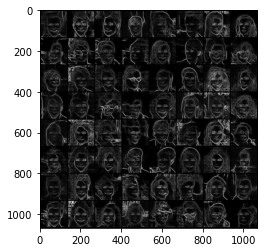

In [8]:
with torch.no_grad():
    # Generate batch of fake images
    fake_image = model(fixed_noise).to(device)
    
    # Put generated images into a grid
    image = np.transpose(vutils.make_grid(fake_image, padding = 5, normalize=True), (1, 2, 0))
    
    # Display and save grid
    plt.imshow(image)
    plt.imsave(model_dir + 'sample.png', np.array(image))

### Save generated images

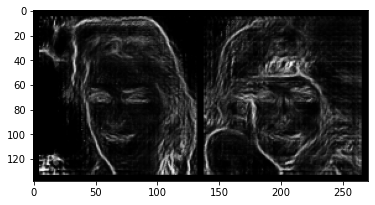

In [14]:
batch = 3
samples = 17
output_dir = '../data/control_samples/data/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

generated = 0
with torch.no_grad():
    while generated < samples:
        batch = min(samples - generated, batch)
        noise = torch.randn(batch, nz, 1, 1, device=device)
        fake_images = model(noise).to(device)
        
        for i in range(batch):
            image = np.transpose(vutils.make_grid(fake_images[i], padding = 0, normalize=True), (1, 2, 0))
            plt.imsave(output_dir + str(generated) + '.png', np.array(image))
            generated += 1
        
    # Put generated images into a grid
    image = np.transpose(vutils.make_grid(fake_images, padding = 5, normalize=True), (1, 2, 0))
    
    # Display and save grid
    plt.imshow(image, cmap='gray')